In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "data.xlsx"

#Create Dataframes from each sheet in data file

staticTare = pd.read_excel(
    FILE,
    sheet_name="StaticTare",
)

noGroundPlate = pd.read_excel(
    FILE,
    sheet_name="NoGroundPlate",
)

dt = pd.read_excel(
    FILE,
    sheet_name="DynamicTare",
)

threeIN = pd.read_excel(
    FILE,
    sheet_name="3in",
)

fiveIN = pd.read_excel(
    FILE,
    sheet_name="5.625in",
)

# Split the 4 runs

# static_tare = df[:][df["Run #"] == "2 w/o Tare"]
# static_tare = static_tare.reset_index(drop=True)
# # Round alpha to match columns
# static_tare["Alpha (deg)"] = static_tare["Alpha (deg)"].round()
# # duplicate missing row
# duplicate = static_tare[static_tare["Alpha (deg)"] == 2.0]
# duplicate_index = duplicate.index.to_list()[0] + 1
# duplicate["Alpha (deg)"] = 6.0
# static_tare_start = static_tare.iloc[:duplicate_index]
# static_tare_end = static_tare.iloc[duplicate_index:]
# static_tare = pd.concat([static_tare_start, duplicate, static_tare_end])
# static_tare = static_tare.reset_index(drop=True)

run_1 = noGroundPlate #[:][(noGroundPlate["Run #"] == "3 w/o Tare") & (noGroundPlate["Q (psf)"] > 1)]
run_1 = run_1.reset_index(drop=True)
run_1["AOA"] = run_1["AOA"].round()

run_2 = threeIN #[:][(df["Run #"] == "4 w/o Tare") & (df["Q (psf)"] > 1)]
run_2 = run_2.reset_index(drop=True)
run_2["AOA"] = run_2["AOA"].round()

run_3 = fiveIN #[:][(df["Run #"] == "4 w/o Tare") & (df["Q (psf)"] > 1)]
run_3 = run_3.reset_index(drop=True)
run_3["AOA"] = run_3["AOA"].round()

How to use tares
1. Subtract static loads
  - $L = L_{run} - L_{st}$
2. Convert to coefficients
  - $C_L = \frac{L}{q_{run} S}$
3. Subtract dynamic tare coefficients
  - $C_L = {C_L}_\text{run} - {C_L}_\text{dyn}$

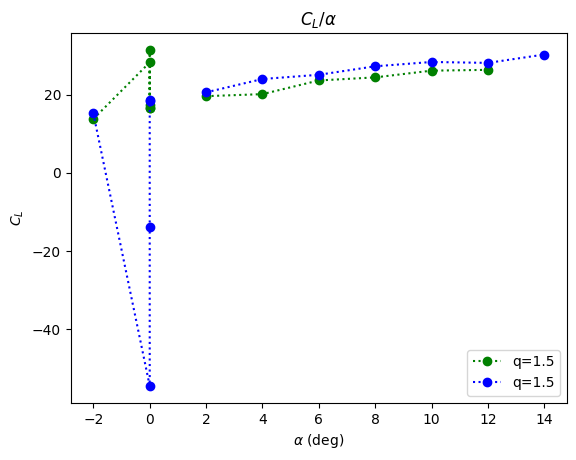

In [48]:
# add non-dimensionalized bits to dynamic tare
dt["lift_coefficient"] = dt["L (lb)"].div(dt["Q (lb/ft.sq)"])
dt["drag_coefficient"] = dt["D (lb)"].div(dt["Q (lb/ft.sq)"])
dt["moment_coefficient"] = dt["PM (lb.ft)"].div(dt["Q (lb/ft.sq)"])

# Find the dynamic tare that matches the target best
q_1_target = 1.5
run_1_dt = dt.iloc[(dt["Q (lb/ft.sq)"] - q_1_target).abs().argsort()[:1]]
#q_2_target = 3
run_2_dt = dt.iloc[(dt["Q (lb/ft.sq)"] - q_1_target).abs().argsort()[:1]]

# wing shape vars
in_to_ft = 12
span = 7.1 / in_to_ft
chord_root = 3.17 / in_to_ft
chord_tip = 1.57 / in_to_ft
# wing is trapezoidal
wing_area = 0.5 * (chord_root + chord_tip) * span / 2

# apply static tares
run_1["L (lb)"] = run_1["L (lb)"] - staticTare["L (lb)"]
run_1["D (lb)"] = run_1["D (lb)"] - staticTare["D (lb)"]
run_1["PM (lb.ft)"] = run_1["PM (lb.ft)"] - staticTare["PM (lb.ft)"]

run_2["L (lb)"] = run_2["L (lb)"] - staticTare["L (lb)"]
run_2["D (lb)"] = run_2["D (lb)"] - staticTare["D (lb)"]
run_2["PM (lb.ft)"] = run_2["PM (lb.ft)"] - staticTare["PM (lb.ft)"]

# adjust moment center
dx = 0.847 / 12
dy = 3.125 / 12
run_1["PM (lb.ft)"] = (
    run_1["PM (lb.ft)"] + dy * run_1["D (lb)"] - dx * run_1["L (lb)"]
)
run_2["PM (lb.ft)"] = (
    run_2["PM (lb.ft)"] + dy * run_2["D (lb)"] - dx * run_2["L (lb)"]
)

# run 1 coefficients
run_1["lift_coefficient"] = run_1["L (lb)"].div(run_1["Q (lb/ft.sq)"] * wing_area)
run_1["drag_coefficient"] = run_1["D (lb)"].div(run_1["Q (lb/ft.sq)"] * wing_area)
run_1["moment_coefficient"] = run_1["PM (lb.ft)"].div(run_1["Q (lb/ft.sq)"] * wing_area)
run_1.lift_coefficient = run_1.lift_coefficient - run_1_dt.lift_coefficient.values[0]
run_1.drag_coefficient = run_1.drag_coefficient - run_1_dt.drag_coefficient.values[0]
run_1.moment_coefficient = (
    run_1.moment_coefficient - run_1_dt.moment_coefficient.values[0]
)

# run 2 coefficients
run_2["lift_coefficient"] = run_2["L (lb)"].div(run_2["Q (lb/ft.sq)"] * wing_area)
run_2["drag_coefficient"] = run_2["D (lb)"].div(run_2["Q (lb/ft.sq)"] * wing_area)
run_2["moment_coefficient"] = run_2["PM (lb.ft)"].div(run_2["Q (lb/ft.sq)"] * wing_area)
run_2.lift_coefficient = run_2.lift_coefficient - run_2_dt.lift_coefficient.values[0]
run_2.drag_coefficient = run_2.drag_coefficient - run_2_dt.drag_coefficient.values[0]
run_2.moment_coefficient = (
    run_2.moment_coefficient - run_2_dt.moment_coefficient.values[0]
)

run_1_sorted = run_1.sort_values(by="AOA")
run_2_sorted = run_2.sort_values(by="AOA")

fig, ax = plt.subplots()
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_ylabel("$C_L$")
ax.set_title("$C_L / \\alpha$")
(line_1,) = ax.plot(run_1_sorted["AOA"], run_1_sorted.lift_coefficient, "go:")
line_1.set_label("q=1.5")
(line_2,) = ax.plot(run_2_sorted["AOA"], run_2_sorted.lift_coefficient, "bo:")
line_2.set_label("q=1.5")
_ = ax.legend()

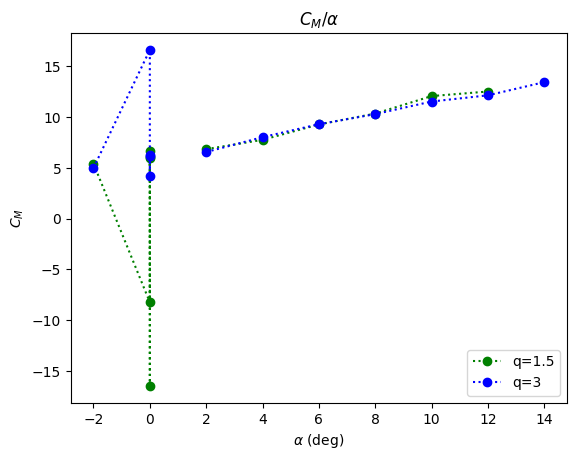

In [49]:
fig, ax = plt.subplots()
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_ylabel("$C_M$")
ax.set_title("$C_M / \\alpha$")
line_1, = ax.plot(run_1_sorted["AOA"], run_1_sorted.moment_coefficient, "go:")
line_1.set_label("q=1.5")
line_2, = ax.plot(run_2_sorted["AOA"], run_2_sorted.moment_coefficient, "bo:")
line_2.set_label("q=3")
_ =  ax.legend()

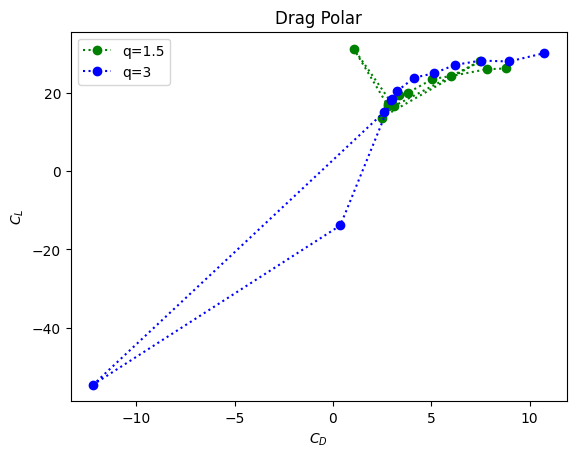

In [50]:
fig, ax = plt.subplots()
ax.set_xlabel("$C_D$")
ax.set_ylabel("$C_L$")
ax.set_title("Drag Polar")
line_1, = ax.plot(run_1_sorted.drag_coefficient, run_1_sorted.lift_coefficient, "go:")
line_1.set_label("q=1.5")
line_2, = ax.plot(run_2_sorted.drag_coefficient, run_2_sorted.lift_coefficient, "bo:")
line_2.set_label("q=3")
_ =  ax.legend()

In [ ]:
hide_cols = [
    # "Run #",
    # "Point #",
    "Time",
    # "Beta (deg)",
    # "Phi (deg)",
    # "Q (psf)",
    # "Side Force (lb)",
    # "Yaw (lb-ft)",
    # "Roll (lb-ft)",
    # "Lift StDev (lb)",
    # "Drag StDev (lb)",
    # "Side Force StDev (lb)",
    # "Pitch StDev (lb-ft)",
    # "Yaw StDev (lb-ft)",
    # "Roll StDev (lb-ft)",
    # "Q StDev (psf)",
    # "Alpha StDev (deg)",
    # "Beta StDev (deg)",
    # "x offset (in)",
    # "y offset (in)",
    # "z offset (in)",
    # "Ref Area (sqf)",
    # "Ref Length (ft)",
    # "Re",
    "COMMENTS",
    # "Z (deg)",
    # "Y (deg)",
    # "X (deg)",
    # "Calibration",
    "AOA Std. Dev.",
    "L Std. Dev. (lb)",
    "D Std. Dev. (lb)",
    "PM Std. Dev. (lb.ft)",
    "Q Std. Dev. (lb/ft.sq)",
    "Q (lb/ft.sq)",
]
run_1.style.hide(
    hide_cols,
    axis="columns",
).relabel_index(
    [
        "AOA (lb)",
        "L (lb)",
        "D (lb)",
        "Pitching Moment",
        "Lift Coefficient",
        "Drag Coefficient",
        "Moment Coefficient",
    ],
    axis="columns",
).format(
    {
        "Alpha (deg)": "{:.0f}",
        "Lift (lb)": "{:.3g}",
        "Drag (lb)": "{:.3g}",
        "Pitch (lb-ft)": "{:.3g}",
    }
)

ValueError: ``labels`` must be of length equal to the number of visible labels along ``axis`` (8).

In [ ]:

run_2.style.hide(
    hide_cols,
    axis="columns",
).relabel_index(
    [
        "Alpha (deg)",
        "Lift (lb)",
        "Drag (lb)",
        "Pitch (lb-ft)",
        "Lift Coefficient",
        "Drag Coefficient",
        "Moment Coefficient",
    ],
    axis="columns",
).format(
    {
        "Alpha (deg)": "{:.0f}",
        "Lift (lb)": "{:.3g}",
        "Drag (lb)": "{:.3g}",
        "Pitch (lb-ft)": "{:.3g}",
    }
)

ValueError: ``labels`` must be of length equal to the number of visible labels along ``axis`` (8).